### Pull data from database using SQL queries and store the data in pandas dataframe for data analysis

In [266]:
import psycopg2
import psycopg2.extras
import csv
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import ks_2samp
from scipy import stats
import statsmodels.api as sm
from config2 import params2

#set options for displaying all the columns and rows
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

In [108]:
# pull all the necessary data from multiple table using joins
conn = psycopg2.connect(**params2)
cursor = conn.cursor()
stmt = ("select pd.id AS program_date_id, s.school_name, p.program_name, l.name AS campus_location, pd.start_date,pd.end_date, pd.graduation_rate, pd.median_salary_180days   FROM bootcamps_edu.School s JOIN bootcamps_edu.School_Program_Location spl ON s.id=spl.school_id JOIN bootcamps_edu.Program p ON p.id = spl.program_id JOIN bootcamps_edu.Location l ON l.id = spl.location_id JOIN bootcamps_edu.Program_Date pd ON pd.school_program_location_id = spl.id;")
cursor.execute(stmt)
result = cursor.fetchall()
print(result)

#create a list of columns names and create dataframe with pulled data and columns names
columns = ['id', 'school_name', 'program_name', 'campus_location', 'start_date', 'end_date', 'graduation_rate','median_salary_180days']
df = pd.DataFrame(result, columns=columns)


[(41, 'The Tech Academy', 'Python Developer BootCamp', 'Online', datetime.date(2021, 1, 1), datetime.date(2021, 6, 30), Decimal('78.3'), Decimal('52000')), (1, 'The Tech Academy', 'Python Developer BootCamp', 'Online', datetime.date(2021, 7, 1), datetime.date(2021, 12, 31), Decimal('82.4'), Decimal('65000')), (2, 'The Tech Academy', 'Data Science BootCamp', 'Online', datetime.date(2021, 1, 1), datetime.date(2021, 6, 30), Decimal('100.0'), Decimal('45180')), (67, 'Turing School of Software and Design', 'Back End Engineering', 'Online', datetime.date(2022, 1, 1), datetime.date(2022, 6, 30), Decimal('62.1'), Decimal('85000.00')), (39, 'Turing School of Software and Design', 'Back End Engineering', 'Online', datetime.date(2021, 7, 1), datetime.date(2021, 12, 31), Decimal('48.1'), Decimal('86500')), (3, 'Turing School of Software and Design', 'Back End Engineering', 'Online', datetime.date(2021, 1, 1), datetime.date(2021, 6, 30), Decimal('68.0'), Decimal('75000')), (33, 'Codeup', 'Full-Stac

In [109]:
#pull the skills' names from table Skill, add each skill name as column to the dataframe and set values to null
stmt = ("select Skill from bootcamps_edu.Skill")
cursor.execute(stmt)
result = cursor.fetchall()
print(result)
skills = [r[0] for r in result]
for skill in skills:
    df[skill] = None

[('java',), ('csharp_net',), ('html',), ('css',), ('javascript',), ('es6',), ('jquery',), ('nodejs',), ('reactjs',), ('redux',), ('heroku',), ('sql',), ('mysql',), ('postgress',), ('mongodb',), ('firebase',), ('git',), ('spring',), ('api',), ('applied_stats',), ('python',), ('r',), ('regression',), ('classification',), ('clustering',), ('time_series_analysis',), ('anomaly_detection',), ('language_processing',), ('machine_learning',), ('advanced_topics',), ('story_telling_with_data',), ('domain_expertise_development',)]


In [110]:
#pull each program id and each skill taught at each program
stmt = ("select pd.id, sk.skill from bootcamps_edu.Skill sk JOIN bootcamps_edu.Program_Skill ps ON ps.skill_id = sk.id JOIN bootcamps_edu.Program_Date pd ON ps.school_program_date_id = pd.id")
cursor.execute(stmt)
result = cursor.fetchall()
print(result)
cursor.close()

[(1, 'html'), (1, 'css'), (1, 'javascript'), (1, 'sql'), (1, 'python'), (2, 'html'), (2, 'css'), (2, 'javascript'), (2, 'sql'), (2, 'applied_stats'), (2, 'python'), (2, 'r'), (2, 'regression'), (2, 'classification'), (2, 'clustering'), (2, 'time_series_analysis'), (2, 'anomaly_detection'), (2, 'language_processing'), (2, 'machine_learning'), (2, 'advanced_topics'), (2, 'story_telling_with_data'), (2, 'domain_expertise_development'), (4, 'java'), (4, 'html'), (4, 'css'), (4, 'javascript'), (4, 'jquery'), (4, 'mysql'), (4, 'git'), (4, 'spring'), (5, 'html'), (5, 'css'), (5, 'javascript'), (5, 'reactjs'), (5, 'sql'), (5, 'postgress'), (5, 'git'), (5, 'python'), (6, 'java'), (6, 'csharp_net'), (6, 'html'), (6, 'css'), (6, 'javascript'), (6, 'sql'), (7, 'sql'), (7, 'applied_stats'), (7, 'python'), (7, 'regression'), (7, 'classification'), (7, 'clustering'), (7, 'time_series_analysis'), (7, 'anomaly_detection'), (7, 'language_processing'), (7, 'machine_learning'), (7, 'advanced_topics'), (7,

In [111]:
# sort id values in descending order
df = df.sort_values(['id'])

# reset index number to be in order
df = df.reset_index(drop=True)

In [112]:
# insert 1 for each skill present at the program for appropriate program id
for r in result:
    df.loc[r[0]-1, r[1]] = 1

### Exploratory Data Analysis

In [114]:
sns.set()

In [125]:
#we see that most null values are present in skills
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            67 non-null     int64 
 1   school_name                   67 non-null     object
 2   program_name                  67 non-null     object
 3   campus_location               67 non-null     object
 4   start_date                    67 non-null     object
 5   end_date                      67 non-null     object
 6   graduation_rate               67 non-null     object
 7   median_salary_180days         67 non-null     object
 8   java                          28 non-null     object
 9   csharp_net                    25 non-null     object
 10  html                          45 non-null     object
 11  css                           45 non-null     object
 12  javascript                    45 non-null     object
 13  es6                   

In [132]:
df.columns

Index(['id', 'school_name', 'program_name', 'campus_location', 'start_date',
       'end_date', 'graduation_rate', 'median_salary_180days', 'java',
       'csharp_net', 'html', 'css', 'javascript', 'es6', 'jquery', 'nodejs',
       'reactjs', 'redux', 'heroku', 'sql', 'mysql', 'postgress', 'mongodb',
       'firebase', 'git', 'spring', 'api', 'applied_stats', 'python', 'r',
       'regression', 'classification', 'clustering', 'time_series_analysis',
       'anomaly_detection', 'language_processing', 'machine_learning',
       'advanced_topics', 'story_telling_with_data',
       'domain_expertise_development'],
      dtype='object')

In [133]:
# from info() above we see that majority columns have values stored as strings, for further analysis we will convert them to decimal values
cols_list = ['graduation_rate', 'median_salary_180days', 'java',
       'csharp_net', 'html', 'css', 'javascript', 'es6', 'jquery', 'nodejs',
       'reactjs', 'redux', 'heroku', 'sql', 'mysql', 'postgress', 'mongodb',
       'firebase', 'git', 'spring', 'api', 'applied_stats', 'python', 'r',
       'regression', 'classification', 'clustering', 'time_series_analysis',
       'anomaly_detection', 'language_processing', 'machine_learning',
       'advanced_topics', 'story_telling_with_data',
       'domain_expertise_development']
df[cols_list] = df[cols_list].astype(float)

In [136]:
df.describe()

,id,graduation_rate,median_salary_180days,java,csharp_net,html,css,javascript,es6,jquery,nodejs,reactjs,redux,heroku,sql,mysql,postgress,mongodb,firebase,git,spring,api,applied_stats,python,r,regression,classification,clustering,time_series_analysis,anomaly_detection,language_processing,machine_learning,advanced_topics,story_telling_with_data,domain_expertise_development
count,67.000000,67.000000,67.000000,28.0,25.0,45.0,45.0,45.0,4.0,10.0,7.0,13.0,4.0,2.0,40.0,8.0,10.0,4.0,2.0,19.0,8.0,5.0,5.0,15.0,1.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,5.0
mean,34.000000,85.122388,71595.492537,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,19.485037,12.652701,23598.960114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,48.100000,37440.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,17.500000,80.950000,57060.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,34.000000,89.300000,65000.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,50.500000,94.700000,75000.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,67.000000,100.000000,140000.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


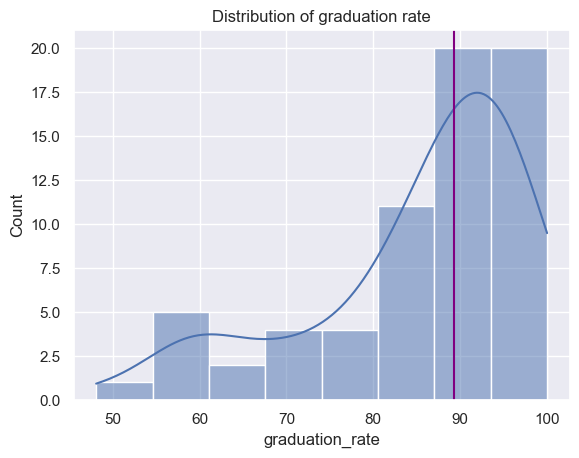

In [142]:
#distribution of graduation rate
xmedian = np.median(df['graduation_rate'])
sns.histplot(data = df, x = 'graduation_rate', kde=True)
plt.axvline(xmedian, c = "purple")
plt.title("Distribution of graduation rate");

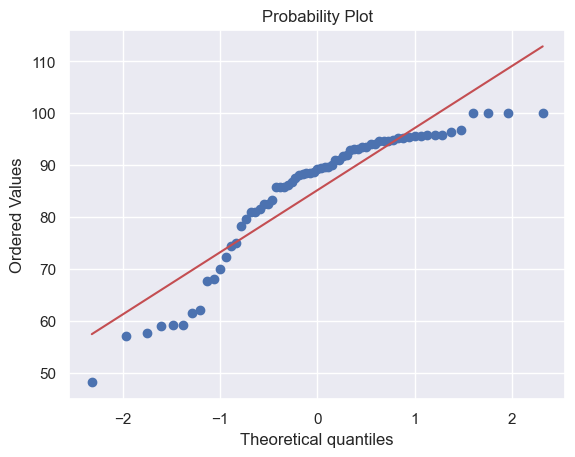

In [150]:
scipy.stats.probplot(df['graduation_rate'].dropna(),dist='norm',plot=sns.mpl.pyplot);

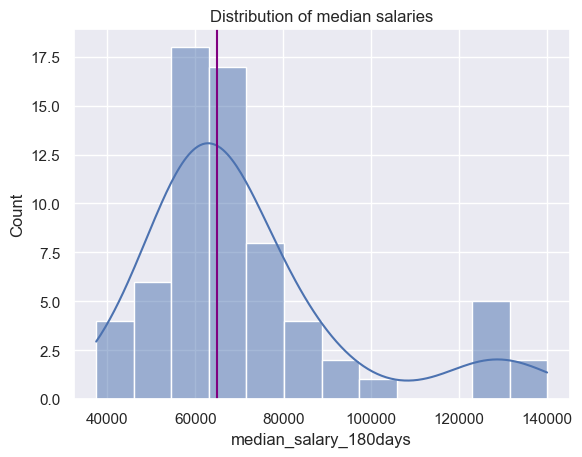

In [145]:
#distribution of median salary 180 days after graduation
xmedian = np.median(df['median_salary_180days'])
sns.histplot(data = df, x = 'median_salary_180days',kde=True)
plt.axvline(xmedian,c = "purple")
plt.title("Distribution of median salaries");

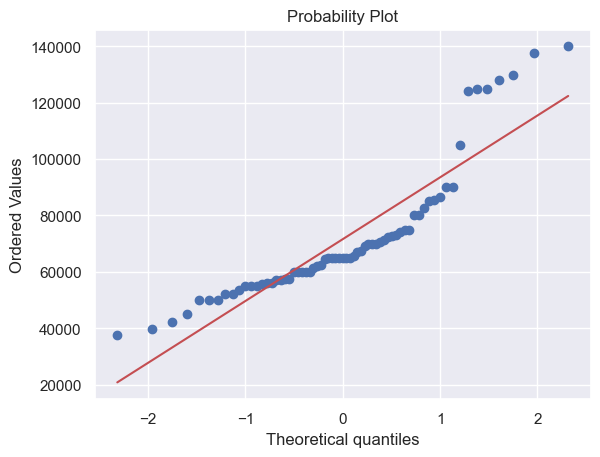

In [151]:
scipy.stats.probplot(df['median_salary_180days'].dropna(),dist='norm',plot=sns.mpl.pyplot);

### KS test

#### The null hypothesis: There are no signifcant difference between median salaries distributions for remote and onsite positions

In [271]:
# Subset data by program location
remote = ['Online','Remote']
onsite = ['Boston', 'Chicago', 'Cincinnati', 'Cleveland', 'Columbus', 'Dallas', 'Los Angeles', 'New York', 'Philadelphia', 
         'Pittsburgh', 'Salt Lake City', 'San Antonio','San Antonio - Vogue', 'Tokyo', 'Toronto', 'Wilmington']
location1 = df[df['campus_location'].isin(remote)]['median_salary_180days']
location2 = df[df['campus_location'].isin(onsite)]['median_salary_180days']

# Perform KS test
statistic, p_value = ks_2samp(location1, location2)


print("KS test statistic:", statistic)
print("p-value:", p_value)

KS test statistic: 0.29554263565891475
p-value: 0.10495022255796234


#### The p-value > 0.05, we fail to reject the null hypothesis

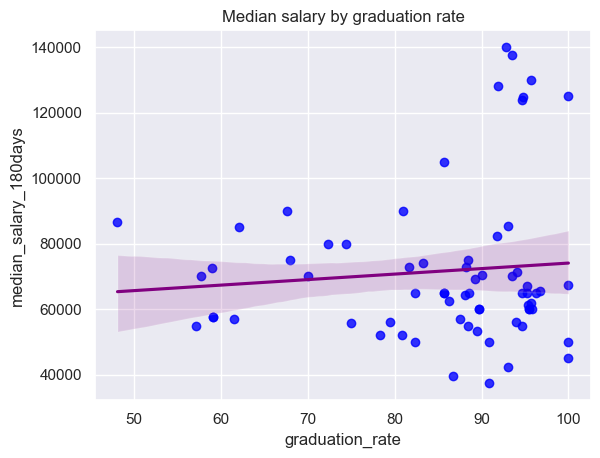

In [273]:
sns.regplot(data = df, x='graduation_rate',y='median_salary_180days', scatter_kws={'color': 'blue'}, line_kws={'color':'purple'})
plt.title('Median salary by graduation rate');

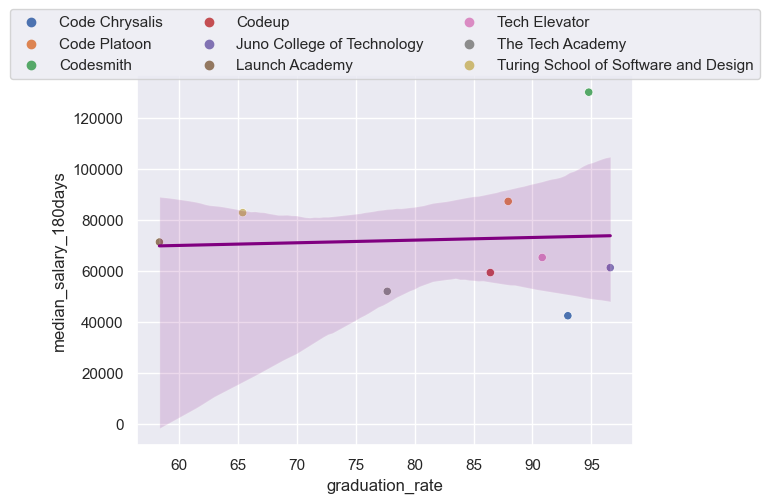

In [274]:
mean_grad_rate = df.groupby('school_name')['graduation_rate'].mean().reset_index()
avg_medsalary = df.groupby('school_name')['median_salary_180days'].mean().reset_index()
merged = pd.merge(mean_grad_rate,avg_medsalary, on='school_name')
sns.scatterplot(data=merged, x='graduation_rate',y='median_salary_180days',hue='school_name', legend='auto')
sns.regplot(data=merged, x='graduation_rate', y='median_salary_180days', scatter=False, color='purple')
legend = plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', ncol=3);


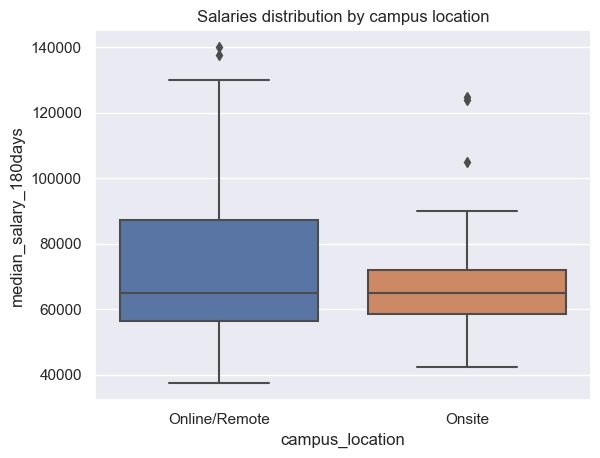

In [275]:
sns.boxplot(x= df['campus_location'].apply(lambda x: "Online/Remote" if x in ['Online','Remote'] else 'Onsite'), y = df['median_salary_180days'])
plt.title('Salaries distribution by campus location');

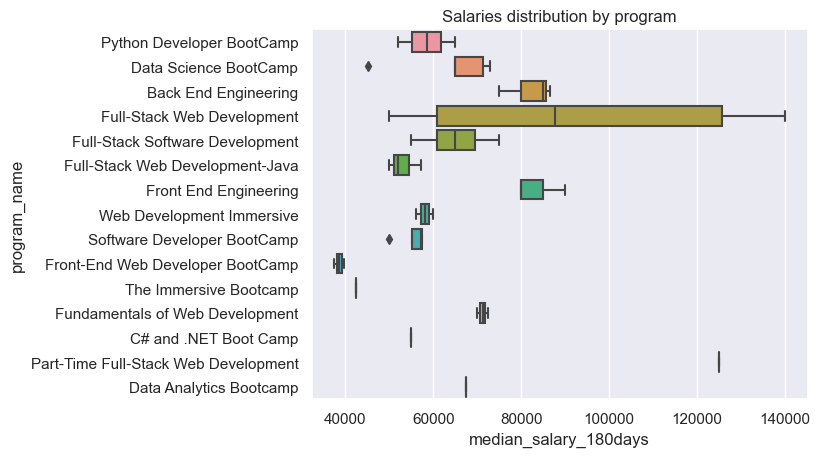

In [276]:
sns.boxplot(x = df['median_salary_180days'], y = df['program_name'])
plt.title('Salaries distribution by program');

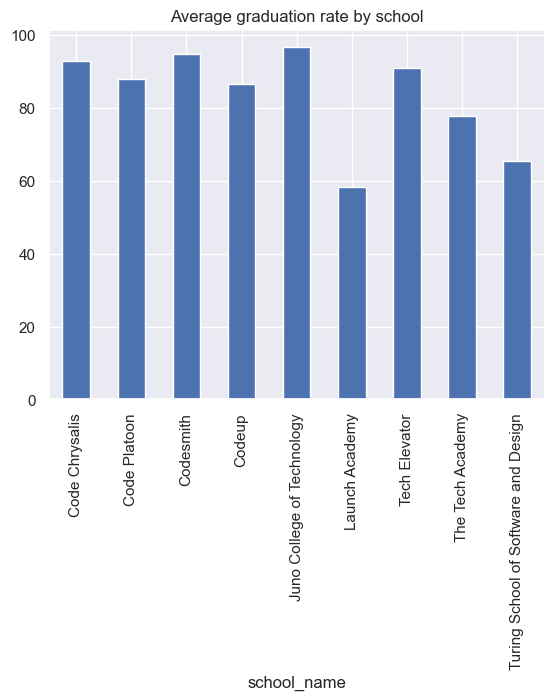

In [277]:

aver_graduation = df.groupby('school_name')['graduation_rate'].mean()
aver_graduation.plot(kind ='bar')
plt.title('Average graduation rate by school');


In [278]:
# select just the columns containing skills
cols =  ['java', 'csharp_net', 'html', 'css', 'javascript', 'es6', 'jquery',
       'nodejs', 'reactjs', 'redux', 'heroku', 'sql', 'mysql', 'postgress',
       'mongodb', 'firebase', 'git', 'spring', 'api', 'applied_stats',
       'python', 'r', 'regression', 'classification', 'clustering',
       'time_series_analysis', 'anomaly_detection', 'language_processing',
       'machine_learning', 'advanced_topics', 'story_telling_with_data',
       'domain_expertise_development']
# create new dataframe that just contains the skills
skills_df = df[cols]

In [279]:
skills_count = pd.DataFrame(skills_df.apply(lambda x: x.count()))

# sort skills occurencies in descending order
skills_count.rename(columns= { 0:'skill_freq'},inplace=True)
skills_count = skills_count.sort_values(['skill_freq'],ascending=False)


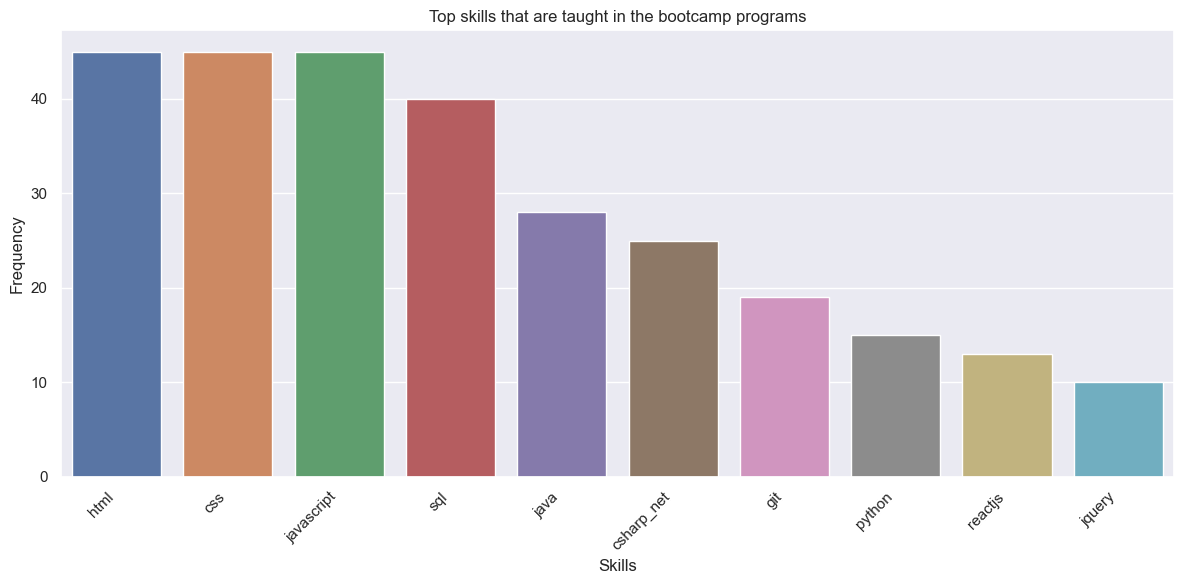

In [280]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=skills_count[:10], x=skills_count[:10].index, y=skills_count[:10]['skill_freq'], ax=ax)
ax.set_title("Top skills that are taught in the bootcamp programs")
ax.set_xlabel("Skills")
ax.set_ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout();
